In [1]:
import pandas as pd
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
df = pd.read_excel('data/employment/GSS.xls',index_col=1)

In [3]:
from code.organize import *

In [4]:
variables = extract_variables('data/employment/GSS.sps')

In [5]:
replace_variables(df,variables)

In [116]:
from code.roughEDA import *

In [56]:
df.sex = df.sex.astype('string')

In [84]:
df[df['sex']=='Female']['wrkstat'].value_counts()

Working fulltime    7284
Keeping house       3047
Retired             2439
Working parttime    2134
School               568
Unempl, laid off     491
Other                418
Temp not working     386
No answer              7
Name: wrkstat, dtype: int64

In [21]:
temp = pd.crosstab(df.wrkstat,df.sex,dropna=False)
temp

,Female,Male
wrkstat,,
Keeping house,3047,255
No answer,7,7
Other,418,365
Retired,2439,2213
School,568,393
Temp not working,386,226
"Unempl, laid off",491,578
Working fulltime,7284,8322
Working parttime,2134,1078


In [52]:
import six
from matplotlib import colors
import random

In [15]:
df.columns

Index([u'year', u'wrkstat', u'hrs2', u'marital', u'sex', u'babies', u'preteen',
       u'teens', u'adults', u'happy'],
      dtype='object')

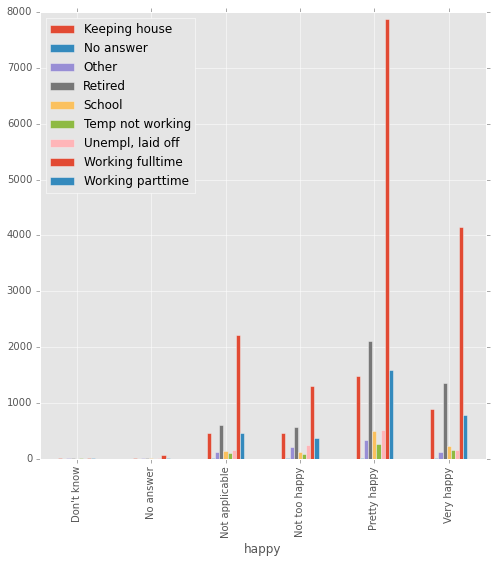

In [111]:
stack_bar(df.happy,df.wrkstat)

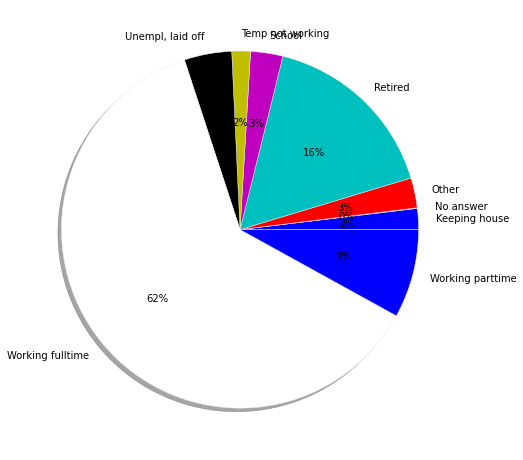

In [42]:
plt.figure(figsize=(8,8))
plt.pie(temp.Male,autopct='%.0f%%',  shadow=True,labels= temp.index);

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1107a03d0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x111627250>], dtype=object)

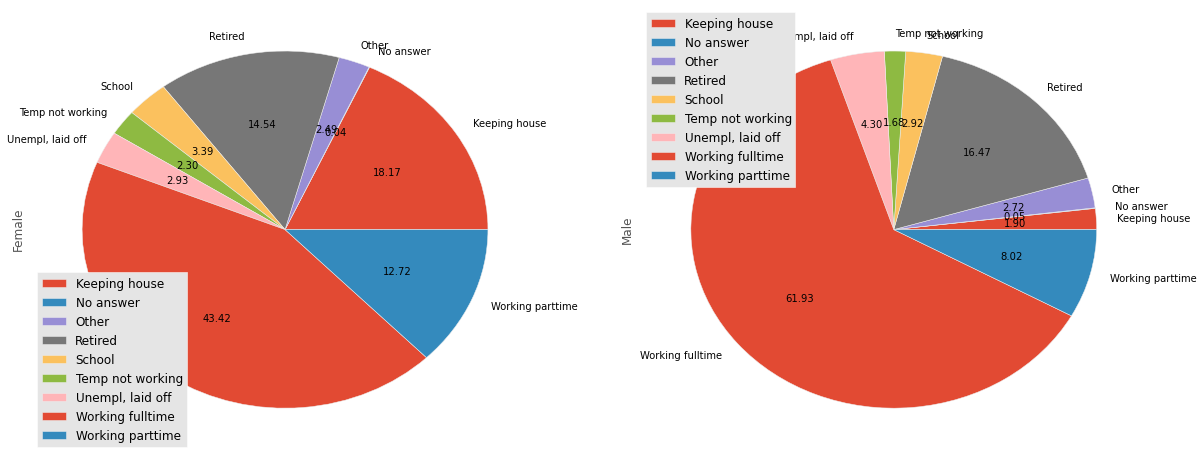

In [88]:
temp.plot(kind = 'pie',subplots=True,figsize=(20,8),autopct='%.2f');

#plt.legend(loc = (0.5, 0), ncol=5)

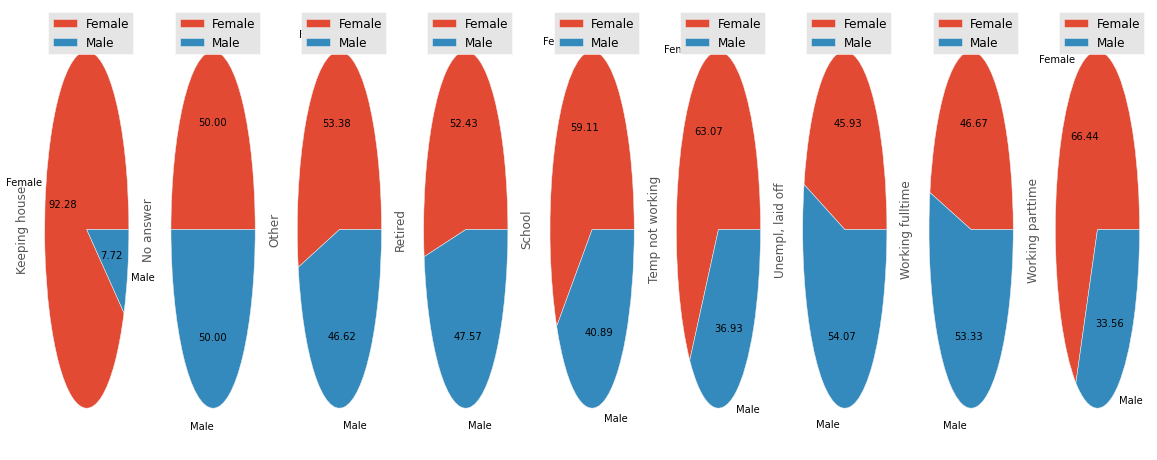

In [102]:
pie_chart(df.wrkstat,df.sex)


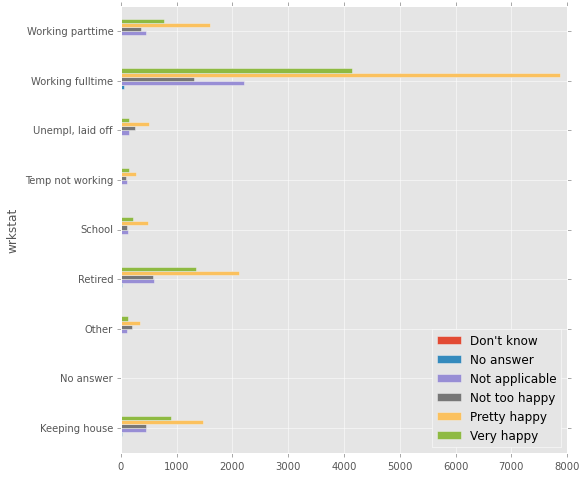

In [118]:
h_bar(df.wrkstat,df.happy)

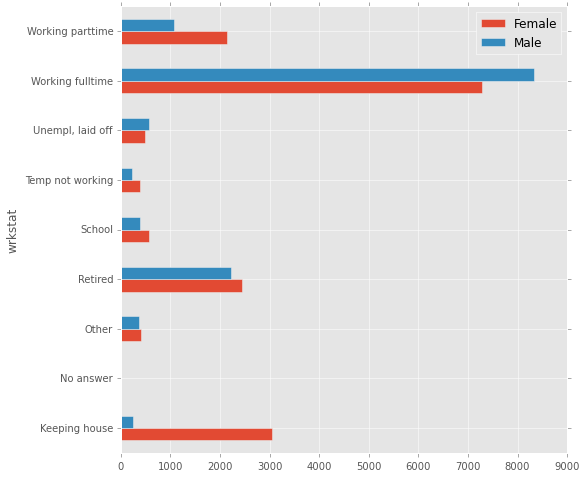

In [112]:
temp.plot(kind = 'barh',figsize=(8,8))

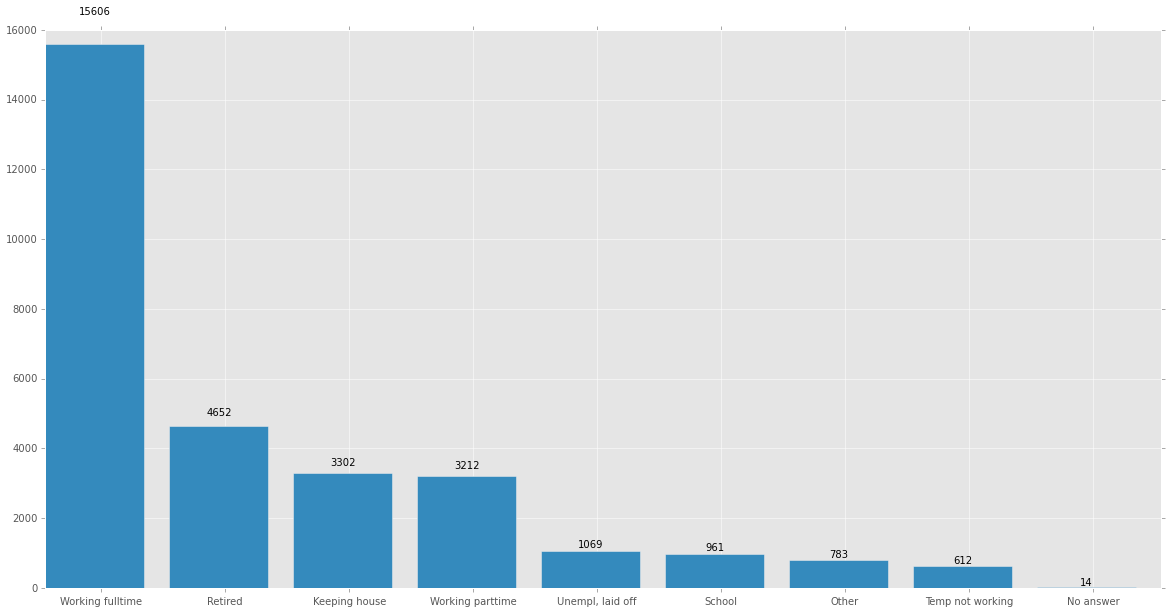

In [33]:
simple_bar(df.wrkstat, size = (20,10))